# Create custom training sets from OpenImages
Built on [Paperspace Gradient](https://www.paperspace.com/), fast VMs with Jupyter and machine learning libraries.

## Hardware requirements
You'll want at least 32GB of RAM to load some of the large metadata tables without bumping into errors. (Future: use Quilt disk slicing to reduce memory pressure.)

Try to minimize running applications and running notebooks if you are encountering memory errors.

## Before you start
```
$ pip instal quilt
```

## For an exploration of how Open Images is stuctured
See [this other notebook](./Discover Open Images.ipynb).

In [2]:
import pandas as pd
import quilt

## Acquire and import OpenImages meta-data
Quilt package: [examples/openimages](https://quiltdata.com/package/examples/openimages)


In [ ]:
quilt.install('examples/openimages', force=True, hash='144ec58d177c7d')
from quilt.data.examples import openimages as oi    

  0%|          | 0.00/2.74G [00:00<?, ?B/s]

  5%|▍         | 133M/2.74G [00:02<00:52, 49.6MB/s]  

In [4]:
oi

<PackageNode '/root/.local/share/QuiltCli/quilt_packages/pkgs/Quilt/examples/openimages'>
github/
test/
train/
validation/
README
build_yml
class_descriptions
classes
classes_bbox
classes_bbox_trainable
classes_trainable

## Function for searching Open Images
Restrict results to **trainable, high-confidence, human-labeled** images.

In [6]:
import operator
import pandas as pd
import re
from quilt.data.examples import openimages as oi

def get_trainable(regex, bbox=False, dry=False, frac=1):
    """search trainable classes for matching keywords
       only return human labeled examples with a Confidence == 1
       
       regex: match against 'Description' of label (hint "^(?!.*FOO).*$" negates FOO)
       bbox: bounding box data?
       dry: stop at label match, don't build actual test/train/validation sets
    """    
    trainable = oi.classes_bbox_trainable() if bbox else oi.classes_trainable()
    descriptions = oi.class_descriptions();
    # Label column is nameless; pandas calls it "0"
    trainable_descriptions = pd.merge(trainable, descriptions, on='0', validate="1:1")
    # Give columns nice names
    trainable_descriptions.columns = ['LabelName', 'Description']
    # Get labels that match regex
    matches = trainable_descriptions[trainable_descriptions['Description'].str.match(regex, flags=re.IGNORECASE)]
    # Print number of matches, matching labels
    n_matches = len(matches)
    print("%s label(s) matching %s" % (n_matches, regex))
    print([m for m in matches['Description'].unique()])
    if (n_matches <= 0 or dry):
        return {}
    # generate lists of links
    data = {}
    for fold in ('train', 'test', 'validation'):
        ann = 'annotations_human_bbox' if bbox else 'annotations_human'
        # trailing () tells quilt to turn attr into a dataframe
        ids = operator.attrgetter("{}.{}".format(fold, ann))(oi)().sample(frac=frac, random_state=1)
        # filter down to high confidence
        ids = ids[ids['Confidence'] == 1]
        matching_ids = pd.merge(matches, ids, on='LabelName', validate="1:m")
        # image urls
        urls = operator.attrgetter("{}.images".format(fold, ann))(oi)()
        matching_urls = pd.merge(matching_ids, urls, on='ImageID')
        data[fold] = matching_urls
        print("{}: {} examples".format(fold, len(matching_urls)))
    return data

## Hmm what kind of images are in Open Images?

In [7]:
# match any description string, dry-run to avoid loading generating training sets
everything = get_trainable('.*', dry=True)

5000 label(s) matching .*
['Isle of man tt', 'Amusement park', 'Roller coaster', 'Granny smith', 'Air show', 'Reflex camera', 'Membranophone', 'String instrument', 'Wind instrument', 'Gourd', 'Lasagne', 'Tortoise', 'Team', 'Vespa', 'Acrylic paint', 'Advertising', 'Meringue', 'Stained glass', 'Plantation', 'Stone tool', 'Narcissus', 'Ferret', 'Magpie', 'Sea turtle', 'Historic house', 'Electronic instrument', 'Hearth', 'General football', 'Egret', 'Tuber', 'Lake district', 'Reindeer', 'Mussel', 'Wildlife', 'Galliformes', 'Cucurbita', 'Domestic short-haired cat', 'Russian blue', 'Bonfire', 'Blacksmith', 'Motor vehicle', 'Gazelle', 'Comics', 'Corset', 'Ocicat', 'Himalayan', 'Chinese new year', 'Alcoholic beverage', 'Sports car', 'Iceberg', 'Firefighter', 'Ambulance', 'Emergency service', 'Fire apparatus', 'Military officer', 'Coast guard', 'Barber', 'Tournament', 'Seabird', 'Businessperson', 'Hiking', 'Bog', 'Flautist', 'Violist', 'Plant pathology', 'Ladder', 'Archaeological site', 'Bento'

In [10]:
doglike = get_trainable('.*dog.*', dry=True)

45 label(s) matching .*dog.*
['Shetland sheepdog', 'Hot dog', 'Bulldog', 'Sled dog', 'Bernese mountain dog', 'Sled dog racing', 'Shiloh shepherd dog', 'Livestock guardian dog', 'Polish hunting dog', 'Native american indian dog', 'Spanish water dog', 'Saarloos wolfdog', 'Dog agility', 'Australian cattle dog', 'Dog sled', 'Hunting dog', 'Wolfdog', 'Police dog', 'Korean jindo dog', 'Northern inuit dog', 'Dog walking', 'Chinese imperial dog', 'Greenland dog', 'French bulldog', 'Toy bulldog', 'Catalan sheepdog', 'Australian bulldog', 'Tamaskan dog', 'Guard dog', 'White english bulldog', 'Canadian eskimo dog', 'Polish lowland sheepdog', 'Maremma sheepdog', 'Street dog', 'English Bulldog', 'Prairie dog', 'Carolina dog', 'Old english bulldog', 'Czechoslovakian wolfdog', 'Dog', 'Dog crate', 'Polish tatra sheepdog', 'Dog bed', 'Dog breed', 'Dog sports']


## Try some interesting searches

In [5]:
m3s = get_trainable('BMW M3')

1 label(s) matching BMW M3
['Bmw m3']
train: 119 examples
test: 44 examples
validation: 7 examples


In [6]:
gw_sharks = get_trainable('great white shark')

1 label(s) matching great white shark
['Great white shark']
train: 182 examples
test: 58 examples
validation: 23 examples


In [7]:
melee_weapon= get_trainable('melee weapon')

1 label(s) matching melee weapon
['Melee weapon']
train: 335 examples
test: 97 examples
validation: 33 examples


## Positive training examples: police_car

In [8]:
police_car = get_trainable('police car')

1 label(s) matching police car
['Police car']
train: 348 examples
test: 86 examples
validation: 26 examples


## Which other kinds of cars do we have?

In [9]:
all_cars = get_trainable('.*car.*', dry=True)

101 label(s) matching .*car.*
['Sports car', 'Supercar', 'Cart', 'Escarpment', 'Shopping cart', 'Carpenter', 'Cardigan', 'Memory card', 'Railroad car', 'Muscle car', 'Carriage', 'Carcharhiniformes', 'Carnivore', 'Cartilaginous fish', 'Cardinal', 'Card game', 'Carpet', 'Carousel', 'Sidecar', 'Caryophyllales', 'Mascarpone', 'Personal luxury car', 'Vintage car', 'Classic car', 'Cartoon', 'Formula one car', 'Volvo cars', 'Concept car', 'Cargo', 'Cable car', 'Antique car', 'Caribbean', 'Light aircraft carrier', 'Car seat', 'Carbonara', 'Porsche carrera gt', 'Scarf', 'Cardigan welsh corgi', 'Caravanserai', 'Compact car', 'World Rally Car', 'Macaroon', 'Personal care', 'Stone carving', 'Indycar series', 'Golf cart', 'Sprint car racing', 'Carton', 'Artocarpus', 'City car', 'Touring car', 'Supercarrier', 'Cargo ship', 'Electric car', 'Cardboard', 'Greeting card', 'Subcompact car', 'Mid-size car', 'Full-size car', 'Armored car', 'Baby carriage', 'First generation nissan z-car (s30)', 'Passenger 

## Negative training examples

In [10]:
# use frac=0.2 to sample the data down to a subset
not_police_car = get_trainable('(formula|race|family|subcompact|model|armored|muscle).*car', frac=0.2)

8 label(s) matching (formula|race|family|subcompact|model|armored|muscle).*car
['Muscle car', 'Formula one car', 'Subcompact car', 'Armored car', 'Family car', 'Model car', 'Race car']
train: 670 examples
test: 871 examples
validation: 258 examples


## Get all train/test/validation data into a single structure

### Balance +/- training examples

In [11]:
folds = ('train', 'test', 'validation')
examples = {}

for f in folds:
    n = len(police_car[f])
    # check for identical schemas before appending
    assert list(police_car[f].columns) == list(not_police_car[f].columns), "expected same schema for +/- examples"
    # random_state=1 for consistent seed
    # this line will throw if there are less than n negative examples
    examples[f] = police_car[f].append(not_police_car[f].sample(n=n, random_state=1))

### Verify that we have positive and negative training examples

In [12]:
examples['train'].sample(n=8, random_state=4)

,LabelName,Description,ImageID,Source,Confidence,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL
568,/m/0ncqpsr,Race car,00fc071e15e7b7e3,verification,1,train,https://farm4.staticflickr.com/4142/4738614146...,https://www.flickr.com/photos/davehamster/4738...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/davehamster/,David Merrett,Young Driver AMR Aston Martin DBR9 Driven by T...,574931,piae16e6ZM5cBMmD+VlTiA==,https://c4.staticflickr.com/5/4142/4738614146_...
293,/m/088l6h,Family car,0001124e2d5104e1,verification,1,train,https://farm2.staticflickr.com/3886/1512944220...,https://www.flickr.com/photos/60900612@N08/151...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/60900612@N08/,Thomas&#x27;s Pics,citroen Traction Advant,3371914,hkBLk/9Pv8CvFtbXbclKeA==,https://c6.staticflickr.com/4/3886/15129442208...
510,/m/0ncqpsr,Race car,020084a5f245e460,verification,1,train,https://farm1.staticflickr.com/3031/2485043313...,https://www.flickr.com/photos/stephanzuercher/...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/stephanzuercher/,Stephan Zuercher,Uber Vogel,4278188,bKH1vEpt3XaKfOfJpYPc+Q==,https://c1.staticflickr.com/4/3031/2485043313_...
40,/m/01h80k,Muscle car,1549b4256680e6e3,verification,1,train,https://farm4.staticflickr.com/5325/1721510237...,https://www.flickr.com/photos/greggjerdingen/1...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/greggjerdingen/,Greg Gjerdingen,1970 Chevrolet Chevelle SS,6750208,bWWvLotl9q8Z0rpzwFN6rg==,https://c4.staticflickr.com/6/5325/17215102373...
189,/m/04qvtq,Police car,669e9d6f57245ff0,verification,1,train,https://farm1.staticflickr.com/3313/3645957385...,https://www.flickr.com/photos/mujitra/3645957385,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/mujitra/,MIKI Yoshihito,Highway patrol car - NISSAN Skyline (V35),12100045,vSA04UX+TUXFO2gt1L+Mdg==,https://c7.staticflickr.com/4/3313/3645957385_...
660,/m/0y8r,Armored car,0060a7504ae9bbf6,verification,1,train,https://farm7.staticflickr.com/3584/3547669979...,https://www.flickr.com/photos/mironset/3547669979,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/mironset/,Ignore Moronic,Enemy Fire,2647567,SL4BSTEa8snMFKs50UXeEg==,https://c6.staticflickr.com/4/3584/3547669979_...
225,/m/04qvtq,Police car,779164b6c21dd87f,verification,1,train,https://c8.staticflickr.com/4/3927/15258628259...,https://www.flickr.com/photos/mpatten/15258628259,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/mpatten/,MARK PATTEN,20111022_venice 019,3144958,N4T8GZGtKfLVqj9oGZ22dA==,https://c4.staticflickr.com/4/3927/15258628259...
146,/m/02_2f1,Formula one car,04dd66f2f4cf7682,verification,1,train,https://farm3.staticflickr.com/8020/7612848942...,https://www.flickr.com/photos/stradablog/76128...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/stradablog/,Tino Rossini,DSC06394,323586,7G3HHXCG665axp4jbWh1Zg==,https://c2.staticflickr.com/9/8020/7612848942_...


## Fetch images to disk (may take a while)

In [13]:
from urllib.request import urlretrieve
import os
import pathlib

for f in folds:
    base = "./data/{}/images/".format(f)
    pathlib.Path(base).mkdir(parents=True, exist_ok=True)

    for i, r in examples[f].iterrows():
        id = r['ImageID']
        url = r['OriginalURL']
        fpath = base + id
        if (not os.path.exists(fpath)):
            try:
                urlretrieve(url, fpath)
            except Exception as e:
                print(e)
                print('problem: {} {}'.format(url, id))
                continue

## Spot check images

In [15]:
! ls data/train/images/12*

data/train/images/123bd533c8b00843  data/train/images/12e2be400a1ae989
data/train/images/12a75be85deb615a


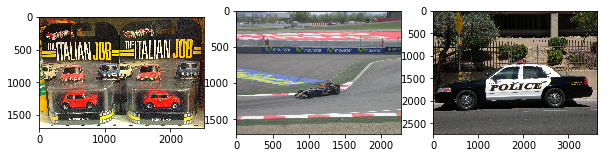

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

imgs = ["data/train/images/123bd533c8b00843",  "data/train/images/12e2be400a1ae989", "data/train/images/12a75be85deb615a"]

columns = 3
rows = 1
fig = plt.figure(figsize=(10, 30))
j = 0
for i in imgs:
    img =  mpimg.imread('./' + i)
    fig.add_subplot(rows, columns, j + 1)
    j += 1
    plt.imshow(img)
plt.show()

## We've still got feature engineering to do
To make this image set production ready we might want do the following:
- Filter the images down (e.g. remove toy cars)
- Add bounding box annotations (`bbox=True` passed to `get_trianable`)
- Normalize images for color, size, format, etc.

But for now we're going to focus on building the dataset in Quilt

## Creating versioned data sets in Quilt

In [17]:
# first make  simple README
!echo "# Police car data from Open Images\nSee [examples/openimages](https://quiltdata.com/package/examples/openimages) for details." > "./data/README.md"

In [18]:
quilt.generate("./data")

Generated build-file ./data/build.yml.


In [19]:
quilt.build("examples/police_car", "./data/build.yml")

Inferring 'transform: id' for train/images/0a8a3ad4149cd52c
Registering ./data/train/images/0a8a3ad4149cd52c...
Inferring 'transform: id' for train/images/046bb8fe53b32324
Registering ./data/train/images/046bb8fe53b32324...
Inferring 'transform: id' for train/images/0409c55d5f4b2fda
Registering ./data/train/images/0409c55d5f4b2fda...
Inferring 'transform: id' for train/images/09e5a582577c6a35
Registering ./data/train/images/09e5a582577c6a35...
Inferring 'transform: id' for train/images/1d41c8b7af0ab6a1
Registering ./data/train/images/1d41c8b7af0ab6a1...
Inferring 'transform: id' for train/images/503e78f6247c20fd
Registering ./data/train/images/503e78f6247c20fd...
Inferring 'transform: id' for train/images/0cb3c55b5471442b
Registering ./data/train/images/0cb3c55b5471442b...
Inferring 'transform: id' for train/images/01e541dab21ca944
Registering ./data/train/images/01e541dab21ca944...
Inferring 'transform: id' for train/images/03d80ff048cd7bba
Registering ./data/train/images/03d80ff048cd

Inferring 'transform: id' for train/images/03827b3d740aa293
Registering ./data/train/images/03827b3d740aa293...
Inferring 'transform: id' for train/images/015b5fc824902d20
Registering ./data/train/images/015b5fc824902d20...
Inferring 'transform: id' for train/images/20d68f78e38d9188
Registering ./data/train/images/20d68f78e38d9188...
Inferring 'transform: id' for train/images/007d1e2377dbd180
Registering ./data/train/images/007d1e2377dbd180...
Inferring 'transform: id' for train/images/01c52dc7a23eb7d4
Registering ./data/train/images/01c52dc7a23eb7d4...
Inferring 'transform: id' for train/images/00d51f34cd78621f
Registering ./data/train/images/00d51f34cd78621f...
Inferring 'transform: id' for train/images/108e2cc9f6078bf9
Registering ./data/train/images/108e2cc9f6078bf9...
Inferring 'transform: id' for train/images/01e1e5fd70410290
Registering ./data/train/images/01e1e5fd70410290...
Inferring 'transform: id' for train/images/50aca1071eb5cb19
Registering ./data/train/images/50aca1071eb5

Inferring 'transform: id' for train/images/00e6d6aa6b3e8c8d
Registering ./data/train/images/00e6d6aa6b3e8c8d...
Inferring 'transform: id' for train/images/033c9a15b1116243
Registering ./data/train/images/033c9a15b1116243...
Inferring 'transform: id' for train/images/053233722eb221c6
Registering ./data/train/images/053233722eb221c6...
Inferring 'transform: id' for train/images/e21d32575394a976
Registering ./data/train/images/e21d32575394a976...
Inferring 'transform: id' for train/images/00ff1f25ad9fea4e
Registering ./data/train/images/00ff1f25ad9fea4e...
Inferring 'transform: id' for train/images/01a12c1940e63645
Registering ./data/train/images/01a12c1940e63645...
Inferring 'transform: id' for train/images/01d258f6d9d6dcf6
Registering ./data/train/images/01d258f6d9d6dcf6...
Inferring 'transform: id' for train/images/03303b0911573a18
Registering ./data/train/images/03303b0911573a18...
Inferring 'transform: id' for train/images/04f27377b52c591d
Registering ./data/train/images/04f27377b52c

Inferring 'transform: id' for train/images/0b0f55eca843394e
Registering ./data/train/images/0b0f55eca843394e...
Inferring 'transform: id' for train/images/01695ee716237700
Registering ./data/train/images/01695ee716237700...
Inferring 'transform: id' for train/images/00254be886e0267f
Registering ./data/train/images/00254be886e0267f...
Inferring 'transform: id' for train/images/01022e1082d29187
Registering ./data/train/images/01022e1082d29187...
Inferring 'transform: id' for train/images/00a5114c7bf6db7f
Registering ./data/train/images/00a5114c7bf6db7f...
Inferring 'transform: id' for train/images/020084a5f245e460
Registering ./data/train/images/020084a5f245e460...
Inferring 'transform: id' for train/images/166b063d0624197b
Registering ./data/train/images/166b063d0624197b...
Inferring 'transform: id' for train/images/dbb4370a9b88bb12
Registering ./data/train/images/dbb4370a9b88bb12...
Inferring 'transform: id' for train/images/1513ac26b68f5202
Registering ./data/train/images/1513ac26b68f

Inferring 'transform: id' for train/images/01f1e6929d18f209
Registering ./data/train/images/01f1e6929d18f209...
Inferring 'transform: id' for train/images/06a643abca9472db
Registering ./data/train/images/06a643abca9472db...
Inferring 'transform: id' for train/images/003f4abfabbfe188
Registering ./data/train/images/003f4abfabbfe188...
Inferring 'transform: id' for train/images/2f4331c937ae2a6f
Registering ./data/train/images/2f4331c937ae2a6f...
Inferring 'transform: id' for train/images/042a62fb735de368
Registering ./data/train/images/042a62fb735de368...
Inferring 'transform: id' for train/images/01c7b7db540d6dd2
Registering ./data/train/images/01c7b7db540d6dd2...
Inferring 'transform: id' for train/images/29dc50636a31537c
Registering ./data/train/images/29dc50636a31537c...
Inferring 'transform: id' for train/images/44842b70f2c45b57
Registering ./data/train/images/44842b70f2c45b57...
Inferring 'transform: id' for train/images/4b1a0da97bd88308
Registering ./data/train/images/4b1a0da97bd8

Inferring 'transform: id' for train/images/070cf22ba1506d28
Registering ./data/train/images/070cf22ba1506d28...
Inferring 'transform: id' for train/images/07e0f073582b795a
Registering ./data/train/images/07e0f073582b795a...
Inferring 'transform: id' for train/images/ff5b4d0323649bef
Registering ./data/train/images/ff5b4d0323649bef...
Inferring 'transform: id' for train/images/04d8b3f63f70a399
Registering ./data/train/images/04d8b3f63f70a399...
Inferring 'transform: id' for train/images/046cce80674b4ff6
Registering ./data/train/images/046cce80674b4ff6...
Inferring 'transform: id' for train/images/00d6ef33e5d2731f
Registering ./data/train/images/00d6ef33e5d2731f...
Inferring 'transform: id' for train/images/007de6281e56f29e
Registering ./data/train/images/007de6281e56f29e...
Inferring 'transform: id' for train/images/0c85203b06bc3205
Registering ./data/train/images/0c85203b06bc3205...
Inferring 'transform: id' for train/images/004abda352a075f5
Registering ./data/train/images/004abda352a0

Inferring 'transform: id' for train/images/04e77b2323489e51
Registering ./data/train/images/04e77b2323489e51...
Inferring 'transform: id' for train/images/09ccc4a061a478c8
Registering ./data/train/images/09ccc4a061a478c8...
Inferring 'transform: id' for train/images/05d85868f6ce59c0
Registering ./data/train/images/05d85868f6ce59c0...
Inferring 'transform: id' for train/images/05bc6ee47b86d6b1
Registering ./data/train/images/05bc6ee47b86d6b1...
Inferring 'transform: id' for train/images/045dfe662a44a9a8
Registering ./data/train/images/045dfe662a44a9a8...
Inferring 'transform: id' for train/images/0ae981e8cf5d743c
Registering ./data/train/images/0ae981e8cf5d743c...
Inferring 'transform: id' for train/images/00492d7583f726db
Registering ./data/train/images/00492d7583f726db...
Inferring 'transform: id' for train/images/00fb62be50bc2353
Registering ./data/train/images/00fb62be50bc2353...
Inferring 'transform: id' for train/images/002a78dc4331b2a6
Registering ./data/train/images/002a78dc4331

Inferring 'transform: id' for train/images/0d3733ca393fe621
Registering ./data/train/images/0d3733ca393fe621...
Inferring 'transform: id' for train/images/2c55c85e25acdcc8
Registering ./data/train/images/2c55c85e25acdcc8...
Inferring 'transform: id' for train/images/0230f87da7aa71df
Registering ./data/train/images/0230f87da7aa71df...
Inferring 'transform: id' for train/images/07282d55bdb05c5e
Registering ./data/train/images/07282d55bdb05c5e...
Inferring 'transform: id' for train/images/045386e8bf3761da
Registering ./data/train/images/045386e8bf3761da...
Inferring 'transform: id' for train/images/01249d34611aeabe
Registering ./data/train/images/01249d34611aeabe...
Inferring 'transform: id' for train/images/02a822ba8ecaedfe
Registering ./data/train/images/02a822ba8ecaedfe...
Inferring 'transform: id' for train/images/48d96851c1f359cf
Registering ./data/train/images/48d96851c1f359cf...
Inferring 'transform: id' for train/images/015815508bb80b29
Registering ./data/train/images/015815508bb8

Inferring 'transform: id' for train/images/06e7196997a77688
Registering ./data/train/images/06e7196997a77688...
Inferring 'transform: id' for train/images/071d35672baf39d8
Registering ./data/train/images/071d35672baf39d8...
Inferring 'transform: id' for train/images/2136ed09353ffa33
Registering ./data/train/images/2136ed09353ffa33...
Inferring 'transform: id' for train/images/0ccaebc8e79417bf
Registering ./data/train/images/0ccaebc8e79417bf...
Inferring 'transform: id' for train/images/00054dab88635bdb
Registering ./data/train/images/00054dab88635bdb...
Inferring 'transform: id' for train/images/01d26b66c3bc9c7b
Registering ./data/train/images/01d26b66c3bc9c7b...
Inferring 'transform: id' for train/images/185b715c321e331c
Registering ./data/train/images/185b715c321e331c...
Inferring 'transform: id' for train/images/019ac7e11f4e63b1
Registering ./data/train/images/019ac7e11f4e63b1...
Inferring 'transform: id' for train/images/05d1b425f280e25c
Registering ./data/train/images/05d1b425f280

Inferring 'transform: id' for test/images/8c71c8dc3d49314d
Registering ./data/test/images/8c71c8dc3d49314d...
Inferring 'transform: id' for test/images/ca31937aacd2a74e
Registering ./data/test/images/ca31937aacd2a74e...
Inferring 'transform: id' for test/images/e859086dbc28fda9
Registering ./data/test/images/e859086dbc28fda9...
Inferring 'transform: id' for test/images/0201c3ace7ff0524
Registering ./data/test/images/0201c3ace7ff0524...
Inferring 'transform: id' for test/images/fd533fe42f34e92a
Registering ./data/test/images/fd533fe42f34e92a...
Inferring 'transform: id' for test/images/361270ef3ae65e3a
Registering ./data/test/images/361270ef3ae65e3a...
Inferring 'transform: id' for test/images/1bd9a8c2a20ac1fd
Registering ./data/test/images/1bd9a8c2a20ac1fd...
Inferring 'transform: id' for test/images/8bfda8dd50d8513c
Registering ./data/test/images/8bfda8dd50d8513c...
Inferring 'transform: id' for test/images/3855519f82bc7cf5
Registering ./data/test/images/3855519f82bc7cf5...
Inferring 

Inferring 'transform: id' for test/images/5986a3e438f9bba4
Registering ./data/test/images/5986a3e438f9bba4...
Inferring 'transform: id' for test/images/cefd81a62af793d2
Registering ./data/test/images/cefd81a62af793d2...
Inferring 'transform: id' for test/images/360470f4329e7d94
Registering ./data/test/images/360470f4329e7d94...
Inferring 'transform: id' for test/images/824f30254162ef67
Registering ./data/test/images/824f30254162ef67...
Inferring 'transform: id' for test/images/9a58e82cdadf6661
Registering ./data/test/images/9a58e82cdadf6661...
Inferring 'transform: id' for test/images/11906f971e8ac49a
Registering ./data/test/images/11906f971e8ac49a...
Inferring 'transform: id' for test/images/9ba770828f3d13fb
Registering ./data/test/images/9ba770828f3d13fb...
Inferring 'transform: id' for test/images/7d65836be92dfe75
Registering ./data/test/images/7d65836be92dfe75...
Inferring 'transform: id' for test/images/b0b0a938e0ad4c36
Registering ./data/test/images/b0b0a938e0ad4c36...
Inferring 

In [20]:
from quilt.data.examples import police_car

In [21]:
police_car

<PackageNode '/root/.local/share/QuiltCli/quilt_packages/pkgs/Quilt/examples/police_car'>
test/
train/
validation/
README

### Add the meta-data (labels, URLs, etc.) to the Quilt package

In [22]:
for f in folds:
    police_car._set([f, 'meta'], examples[f])

In [23]:
police_car.test.meta()

,LabelName,Description,ImageID,Source,Confidence,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL
0,/m/04qvtq,Police car,8bfda8dd50d8513c,verification,1,test,https://c5.staticflickr.com/1/193/444440566_ae...,https://www.flickr.com/photos/christopdesoto/4...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/christopdesoto/,christopdesoto,suffolk Cty MA shrrif (2),114118,jhYQsO0g5S8ijiYK0wnl2A==,https://c8.staticflickr.com/1/193/444440566_1b...
1,/m/04qvtq,Police car,7d65836be92dfe75,verification,1,test,https://farm6.staticflickr.com/3647/3608810734...,https://www.flickr.com/photos/conner395/360881...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/conner395/,Dave Conner,M231 Saab 9-5 Estate - Sweden National Police ...,96079,CHFPMGFcoEacjavX31uenQ==,https://c4.staticflickr.com/4/3647/3608810734_...
2,/m/04qvtq,Police car,9640560b267e167b,verification,1,test,https://c4.staticflickr.com/4/3196/5729417942_...,https://www.flickr.com/photos/nespirit/5729417942,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/nespirit/,826 PARANORMAL,&quot;OFFICER DOWN&quot; MOVIE SHOOT BRIDGEPOR...,4174485,f/kI7q0QrsLMv09sYRr3hQ==,https://c8.staticflickr.com/4/3196/5729417942_...
3,/m/04qvtq,Police car,3caa425417a0db1e,verification,1,test,https://c7.staticflickr.com/4/3901/14636717584...,https://www.flickr.com/photos/conner395/146367...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/conner395/,Dave Conner,Police Service of Scotland vehicles at Inverne...,861733,BH6me69q0EY5IA3ZnWlYFQ==,https://c2.staticflickr.com/4/3901/14636717584...
4,/m/04qvtq,Police car,51786f1929198048,verification,1,test,https://c1.staticflickr.com/6/5004/5641955324_...,https://www.flickr.com/photos/degu_andre/56419...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/degu_andre/,André Gustavo Stumpf,DEMA,3516106,6OKhunCIq2BnlCizCpHqWw==,https://c4.staticflickr.com/6/5004/5641955324_...
5,/m/04qvtq,Police car,63b3f2b3b05e37c9,verification,1,test,https://c2.staticflickr.com/9/8336/8143735483_...,https://www.flickr.com/photos/alecperkins/8143...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/alecperkins/,Alec Perkins,6th & Clinton,1880226,AEVWrTS5vnodkFaYq025hA==,https://c7.staticflickr.com/9/8336/8143735483_...
6,/m/04qvtq,Police car,c6c57829c7ec3af1,verification,1,test,https://farm2.staticflickr.com/23/93531075_dde...,https://www.flickr.com/photos/clanlife/93531075,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/clanlife/,Phil Campbell,Roswell Local Police (or nenar for uk slang),35536,LgPesjnun32HShzASxdr+Q==,https://c8.staticflickr.com/1/23/93531075_dde3...
7,/m/04qvtq,Police car,9208a164c2b0ccce,verification,1,test,https://c7.staticflickr.com/6/5146/5728869113_...,https://www.flickr.com/photos/nespirit/5728869113,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/nespirit/,826 PARANORMAL,&quot;OFFICER DOWN&quot; MOVIE SHOOT BRIDGEPOR...,4220839,OKmHcwXu+lgEQxpK5G9Odw==,https://c4.staticflickr.com/6/5146/5728869113_...
8,/m/04qvtq,Police car,360470f4329e7d94,verification,1,test,https://farm5.staticflickr.com/47/158429460_af...,https://www.flickr.com/photos/beglen/158429460,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/beglen/,"David, Bergin, Emmett and Elliott",walk2_0007,481703,WMbaq6dGftu8WoeXpgVjyw==,https://c8.staticflickr.com/1/47/158429460_af1...
9,/m/04qvtq,Police car,583c01accf90fa4c,verification,1,test,https://c5.staticflickr.com/1/424/19385791006_...,https://www.flickr.com/photos/119886413@N05/19...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/119886413@N05/,amateur photography by michel,Citroën C4 Policía,5554908,lbbMCA/UUZs2KBZ+wt9cTw==,https://c8.staticflickr.com/1/424/19385791006_...


In [24]:
quilt.build("examples/police_car", police_car)

### If you want to push your package, you'll need to log in to Quilt

In [ ]:
quilt.login()

In [27]:
quilt.push("examples/police_car", is_public=True)

Fetching upload URLs from the registry...


  1%|▏         | 24.7M/1.84G [00:00<03:22, 8.96MB/s]

Uploading 902 fragments (1837166291 bytes before compression)...
Fragment 02104e3602b367adfb4704ba4a072b577d215823aa54d11e6645d5319fe0dba2 already uploaded; skipping.
Fragment 0170e3702c1cec7d959350549e99b9793d86a2e53722ad570483f48d53f88155 already uploaded; skipping.
Fragment 02485ceb0c8c8c72c09692488909a49ea05cd702787163b93fd12470ca7ca880 already uploaded; skipping.
Fragment 01923176505190c31c166b9b64e6fef10a8cde9b789a626090ef7a5ddf89bd75 already uploaded; skipping.
Fragment 00113146729de5d8bd999f4c697a4372f4ecaedb07009485acc606e3f576973c already uploaded; skipping.
Fragment 0224d16b5d1d0c2ef19d01158001908eebeeb006d52b14fff7085a4baa94facf already uploaded; skipping.
Fragment 03cb9fff129ec9b8304a4bcab3ceb9dc0d722282a8cd082e587e4a8fbd0a1951 already uploaded; skipping.
Fragment 0493f8fa0a4e631025cf082235498f197ccb2af6a5279c5bbb04eaf7ac65041b already uploaded; skipping.
Fragment 04eea93b5737080592dde7ee572f7285d61ee7c3b80161196d929b37525711e7 already uploaded; skipping.
Fragment 03d500fb

  5%|▍         | 83.1M/1.84G [00:00<01:39, 17.7MB/s]

Fragment 03d3d6352228d5448f82c0c352669d0aa4a6169218a7d9a8842f407885b8dd78 already uploaded; skipping.
Fragment 079754e476392f7893681b02e67ecf74aeee04d364b3f25bd88505db6192abcd already uploaded; skipping.
Fragment 070c70a0a86be517281852b11931f8d4689857d7e0124bd24e4e550b414c20d9 already uploaded; skipping.
Fragment 0809b35e247015d2998d8e5d886f0bc406592485d36ec10d42c96a6d2ef2d89c already uploaded; skipping.
Fragment 0858751c5aae13dff62c1d6c983332c9ff28c1e52b27a74a2b3f8d35e392ae3d already uploaded; skipping.
Fragment 08dba79898812c8255f70368178e6c7788300b86805af7e1f189d976e0a79e2a already uploaded; skipping.
Fragment 04164603ff0aa736b1ce08cad15eda92e9e5380c47741211dd0a56a17bc3b970 already uploaded; skipping.
Fragment 0466ed366c21802d485703b14ff23a0d84dea3ee7fff8258f98e7f795e3a3eaf already uploaded; skipping.
Fragment 019a125f34a63272b72cde1fe1baf9d8679a6ef80b06e9ccc40d23f4b8ed87ef already uploaded; skipping.
Fragment 0a1a9ed4628fbfac197d0f61480a6b8ffe813240d34953f9e95069befa9b243a already 

 10%|█         | 190M/1.84G [00:00<00:47, 34.4MB/s] 

Fragment 16460c46b438c17b5779ed8236ec0b365c283deb2dcd68b909560d7620e6329c already uploaded; skipping.
Fragment 1668f535138b598114bf2e74a2c4f8ae3039e9623019e2d20577ac008933b35f already uploaded; skipping.
Fragment 12c98eb0fdead20e3cad9ad0b68d39a01564dc2dceba4f867a321faf3e89372e already uploaded; skipping.
Fragment 1407872b89bb87cb3aed5816c371afa7314d68c584f85a6be7b9bd55ea027f2d already uploaded; skipping.
Fragment 16f51044163030c4cee1f2555496272e2c614c39b74eedca003193e2332b8fa8 already uploaded; skipping.
Fragment 16fe673f4d836bf0f7ee74a44615402b796839b7996c09f30c957a3150d1e639 already uploaded; skipping.
Fragment 0611dbe0094bd33bbd5225580fab1007315cc3709be1e1b027cbc6d20fe43b33 already uploaded; skipping.
Fragment 166ae2f93efb499b09dc91fb939afd4242f4da032a01bf282de6a159648ac0ef already uploaded; skipping.
Fragment 15df6dc30b89d4ffe0cb9ae975305fdd9de5af9e73d35507cb78d08165fafd71 already uploaded; skipping.
Fragment 135f26470adf74e41856efd4a4cd310371dd20685a07fe22b7d8f0184a9a2ac0 already 

 14%|█▍        | 260M/1.84G [00:00<00:24, 64.9MB/s]

Fragment 1bd50aaa31f2175aff72a950c1232eb7061f3adc7b80991783d54a1250ea1533 already uploaded; skipping.
Fragment 200dd2bf543da0c7be2b90a43d5b841da4110e896f5b6d94df8ee4b76ed4bdaf already uploaded; skipping.
Fragment 201a41c841cf560646644d8003cf616106899be85ab166b8e9eb0891a229bacf already uploaded; skipping.
Fragment 1fb59e306ea9cda22f3dcbaac9ec867b8de377d91b9f24914ca5644671c6cf0b already uploaded; skipping.
Fragment 1fee9fd010e81aedaec90b5635efd02b13462b11740bf3aa7f74392644b9e9cf already uploaded; skipping.
Fragment 20c905be45a6ea022b171ead675384e5a5508bbe6e9528bd11096586c9af59fc already uploaded; skipping.
Fragment 00e14adb31768c929eeb07f5854fdbd7d40acf9a862b644bcee3991565112aa7 already uploaded; skipping.
Fragment 203c1fb6b2c83c058aeaa1b9a684fdc0da3cb013753d34729204bd5cbf065d7c already uploaded; skipping.
Fragment 21a14562687bd69e9cdfd5cf4a387aef5a6ef5a8fbfb77ca9a3dd9218c833fab already uploaded; skipping.
Fragment 21a1664749e70535bd03700ebb99004247174b3c6dbd76dbfb79d8160264e946 already 

 18%|█▊        | 329M/1.84G [00:01<00:13, 109MB/s] 

Fragment 27ce987a0fc7bd7de65841780f7aabcda718308a2a75ae0ae7bed5249bd4151e already uploaded; skipping.
Fragment 2a466a2e0a8d0d2c771c332f378f6aaa9b23d30e668752c55aead4a864e62461 already uploaded; skipping.
Fragment 1d9bb2e20073291a61ce97d29538a474ec3a6c139db0ba0a558ce57dd063d387 already uploaded; skipping.
Fragment 2a1ba9d61d1d6405f1035fd5f92f3ba063262785678ac3a3e48ab3cee207617b already uploaded; skipping.
Fragment 2ab81955c0e46e0fc92edd58cd63919f7839b6b9c3fd0c1a1bd5b9784c1d9635 already uploaded; skipping.
Fragment 27cd3dd188f914f8e51582634f09dd55ba8af64c0b19c085a2d70473f3239d98 already uploaded; skipping.
Fragment 2be95e36c0e2e79aea296ccaee1a8871fd520d4dabca6a29c44ff1aeeb06b103 already uploaded; skipping.
Fragment 2c72510e3b73e59b2dc1d405f66d4e3f47fea28ebf8460fc4972bda882d625ae already uploaded; skipping.
Fragment 2b771773ee740c9fa4f43503c409a80360f5f4b841b0a1c24ee543f9ee554ee8 already uploaded; skipping.
Fragment 2c91af5defa71cb0c737ad7ba93457cff651817591a1b729ca999e00d41fd9a5 already 

 24%|██▍       | 448M/1.84G [00:01<00:07, 188MB/s]

Fragment 32b4514354b092b706dfdef6d5396dd26f96037a574d42456065245c1cbc76b0 already uploaded; skipping.
Fragment 324e73281dfcea35b93f064ddbc00583620aeb9a8c732fa4347cd4852c83c876 already uploaded; skipping.
Fragment 333311eb8e7b37fb88086eb73d729f31a67bff14752a62727cd1c881595961cc already uploaded; skipping.
Fragment 3350c6c04a40f585f4000df0b5a12b3358bf324b28d55663fb81090aef1a0493 already uploaded; skipping.
Fragment 2ef6faf3bc9f152fce628e172faacee39ef67fd75b987b525a94623216e605b2 already uploaded; skipping.
Fragment 330a197cecefb9a023f38268ad0c053f72aedcf5f82d0df72748a5875a5d51c9 already uploaded; skipping.
Fragment 2e8e338d2f65e1d2001e677684ebf33d4e3aa2cf5902bd000ce4944da4ad2c70 already uploaded; skipping.
Fragment 2ab530f9052a08244d2be97a33d617c5cb885f36aac6798d02ffdd9f34ff876f already uploaded; skipping.
Fragment 3501cb3d352030db571bc7f5bb93df114cfef9cd0ff574903db850d999629d77 already uploaded; skipping.
Fragment 30e3b3e3045e6e4837e79c4618600091c31ddc9f865af5cbff4f8a64e5b791ad already 

Fragment 3bcc1a61fcaff184752f7536b9eee5c0a4b2f13c2089eab29a81929ae08aae5a already uploaded; skipping.
Fragment 3ce23296c473a85af0254ac2c9c3649addbf31610685c4a802bc95ad2d45bf62 already uploaded; skipping.
Fragment 3cb75039d6bdc813205e8f374413da40963ba5943af7a7a32356a5c53d8db4e9 already uploaded; skipping.
Fragment 3b92bad13c4111f8bfc26548c825193fc2e3151ec81397260575bd7363605033 already uploaded; skipping.
Fragment 3b97f7651e5396ee5469362f97dee734979ea455f46692c664d674bad2dd216c already uploaded; skipping.
Fragment 387035f34441a7607b78bc1028b57df33f4ca19d2948fda94f0309b52a82d446 already uploaded; skipping.
Fragment 3cbc6506866764f78488c2c912c8dd9bdcf37113066580e9a5dc8b393208d27d already uploaded; skipping.
Fragment 3b7ed9d3d09c40ca2ea60f3709fbf8bc379d0dc446cdba9ee02e95f5935f3970 already uploaded; skipping.
Fragment 3cfe9adda9793305d8c5214802575b52d56d69e3f81f4a9c60af882c532e2973 already uploaded; skipping.
Fragment 4044bba33f3ca3f6661360b5293bae00c772bcbb9701d9ced2dd20d4f6ac5bcf already 

 34%|███▎      | 616M/1.84G [00:01<00:04, 303MB/s]

Fragment 3e43603902c05a10f636199882a58d3f46fe28798f4298de5319685a212e982f already uploaded; skipping.
Fragment 494a73755bc19db6f8078ef299c2e74a57845c5118bd4e8a5bd1ced17d506075 already uploaded; skipping.
Fragment 42ee0fa4fbe6e0914cc1872d3b1c2ac98f1b6e1a7076aaead24393151a6a5e80 already uploaded; skipping.
Fragment 473d26b06f52a4b1f732759db6b887d70524241d226d2230c262d7fcd3c04f50 already uploaded; skipping.
Fragment 48d924b79e46ceaa6c2ad4bfa65a30ed8614811bbccee2b46422e4d8852736fa already uploaded; skipping.
Fragment 4b07cd7632da339e272fe1e4bbf2f827d3b53170aef9d8da9b20a62df6aa5147 already uploaded; skipping.
Fragment 42d02bfa19b94031dd91f42a58969f2bece5e74da00c0a157a388b010f08e585 already uploaded; skipping.
Fragment 4a9c7e1937d34fb700d476a0eefc43926eee7685c16bf88a1e1ed9c43048240a already uploaded; skipping.
Fragment 4b078e201bdc75adcafdefc5ac49145c0143f11249fab9313787b89c6a4d7021 already uploaded; skipping.
Fragment 4b34bb95417052b1e928d3a981beea4b0733f857bfc0376027c4d128a562264e already 

 37%|███▋      | 678M/1.84G [00:01<00:03, 303MB/s]

Fragment 52c0392c446b8cae9e18d061718bbaeab0ff592262941f1e2a7f9217c3af364f already uploaded; skipping.
Fragment 526f5697a0004eaa6b6750a42472527a05e8ce5c54121ec11aebb44e1b30c357 already uploaded; skipping.
Fragment 32cba864aba79fe15dfba31e32bbbf0be68a8577afdac5b44ec39771376a49e9 already uploaded; skipping.
Fragment 534d4b5c39ae4fd264c2689b6b7fc89f1ff5d67c72b2de81410e8ba1a0fa0928 already uploaded; skipping.
Fragment 53eb3f8368bb3c955818b483f5bd81b6c2bd59dbee4a0fb0754396a10e8eaae1 already uploaded; skipping.
Fragment 5316e9b5fe37249f823f9a4fa99a997a9db26b3f5afb59ae7b2be998665a58a3 already uploaded; skipping.
Fragment 54fdad31b6c97c83e12402bd3de938d367351c4c3b038c9f26d49c2c1ad4b6b3 already uploaded; skipping.
Fragment 52905017c61f9bb00224538683c5531768426b264c098934229fb77f8de8021f already uploaded; skipping.
Fragment 53826a9884d0391d6ea22c43d7fa4e86dea7182e6afce90cefd2004894386da6 already uploaded; skipping.
Fragment 51e14fa65d4d03e7c251bb8871a21da03a3f85752b1d10bf131cb4eebef68d6d already 

 41%|████▏     | 761M/1.84G [00:02<00:03, 325MB/s]

Fragment 5fd6749b5a13bb59b0e9303a801bbb89da876c68566036ca6401f65a0411f8df already uploaded; skipping.
Fragment 581f663c5379f664e243f8c96de0c2058b6b8d682e926f7e0578571fcd86070c already uploaded; skipping.
Fragment 508abe488d5981ff6b755658b5624e4b4bdfdf17d4c052f3b6ad52af058c5500 already uploaded; skipping.
Fragment 605e173b5a0272b3543f6f8a331c070463d2dedc2cf6a4ae865e35190d183f3f already uploaded; skipping.
Fragment 60f629c743f4ad61636bb2b6ed32be2fccff17871f25e38aa6ded492d571f3e6 already uploaded; skipping.
Fragment 588c46e6e77c59cc0c2d2b1b7e62e643d1d19d997a24da3f3360b09ac49f6a74 already uploaded; skipping.
Fragment 5dcecaa01b15af00fd30b8646e15f2eb0aa8346a00c60b9ae322ee1d6dc168c5 already uploaded; skipping.
Fragment 5e4a76eeb546ced240a5a588e7457c17f6bf2a252fd4f0eaa788dba551e46a06 already uploaded; skipping.
Fragment 62345b4777b9292001514ba7f6ef86e12949d5ed88e7b308cc7a479062eb6972 already uploaded; skipping.
Fragment 625ad0010ca4fdaf3d15fdcc877316fea39b09e026a2392c4a08f3ae74506600 already 

 46%|████▌     | 837M/1.84G [00:02<00:02, 357MB/s]

Fragment 5b4e0f8662417d66e1077a3e2bf7a6acb258b73b7adc93b4f727dfb77b661d09 already uploaded; skipping.
Fragment 68df155d33822a39aef12a0d941b3b1779898aeeaa9b210c5a6640e5cc86ff58 already uploaded; skipping.
Fragment 5d68033f7ff1b7c8b155d40c644a25de57c888ede5e2ee124646d3d16ef1baeb already uploaded; skipping.
Fragment 6befd2fa7b053ec5e7925afac2a45c04f66f6a9e5cb8c1707dcf9608b4b920fe already uploaded; skipping.
Fragment 6c295dfe48fbe31fef64ea7604775c3ed0de7c5c84cfd1547bea2dd5e852efe7 already uploaded; skipping.
Fragment 6c42fc3bc8d66bba9f5c230353c540ca4e8d6904f4368fd4b019b1b6f8f165d9 already uploaded; skipping.
Fragment 69c73310936def10445ae896dfc2c427f2839bdb4c69450b18a8ca3350a243aa already uploaded; skipping.
Fragment 69fa82fb61a7b605386df01edc7939a7f07e57599cdde009fb5a007fb166b5a5 already uploaded; skipping.
Fragment 6fd64d6f566671b73ee7841dadcd3ae1749253b46cb4efc7f6d0422adcfebda5 already uploaded; skipping.
Fragment 6ff369ee7bcc8a1a4dd320117ad90e03d787dcdf97bbb2a0202bf25a4b8fa758 already 

 50%|████▉     | 911M/1.84G [00:02<00:02, 371MB/s]

Fragment 74878ccc19b8eb3d33d6cced95fe5cac10d7ea195f14789f01e6aba73fa37fda already uploaded; skipping.
Fragment 760c276c79c3e1a4352d31f7916261c5d37f1d642f19f9e893a2cdaf5237c9ce already uploaded; skipping.
Fragment 7454dae0fa3ebc4cef62cac4385714090c24b115e98df8f7b4891766da4ba54d already uploaded; skipping.
Fragment 72506a111aacf64cbd878e6fcab9d26f11c58aefe17737719508c9fb0fd6b516 already uploaded; skipping.
Fragment 7563d44096bace27043322324e1488f375d5ae164d96b9dbd224d00bffe1975a already uploaded; skipping.
Fragment 73b6b0d3f078cb36587eb3e4503ac8f0553574cc37659523e345f9f8e92309da already uploaded; skipping.
Fragment 76c65b87e4744a5337159a8da4a27690e82ebd3a9a6fbe599df243c5a159e4b2 already uploaded; skipping.
Fragment 783068bd5ad6d84bcc99ece12d212899bc8e8dbd3a969cdbec7a96bb2fcec21b already uploaded; skipping.
Fragment 75004516d10d95475087c5ee6e2d435b5959fcabebc8af3b45d724bd6207fd85 already uploaded; skipping.
Fragment 74a2061be1f82548a1e87c641c071f9e1ea25b35cd6bd539566f16b33dc8e532 already 

Fragment 803791d2f806d7be76d358a9e3fb701404da0419ccf9004a48c9fbf6fe29ee1c already uploaded; skipping.
Fragment 7fd4171b5947700588a6089d58f0fa0e773e512c6f14a580ca90df50cb7e2ddc already uploaded; skipping.
Fragment 7b653ba519645a611ceddeea8a273d3100f40638add2d0b74fca0e4c9a427905 already uploaded; skipping.
Fragment 7415f830cb41eaf489a5090eb7916cc0c68e9457165f5b00eff6ceafa2c841fd already uploaded; skipping.
Fragment 80c6c9f2cbbc1f7286ca30e60e525225039c50776709987cc4e1e8b4f1337e00 already uploaded; skipping.
Fragment 7f54982f1d97be3eacbb98efaeca0225d490e43ca03cdfb2123d3fe3a1207b94 already uploaded; skipping.
Fragment 7f65439ae7765278ece0e3b5f6abc2b12cf2a175e96b9dd9b1876568497c526a already uploaded; skipping.
Fragment 7fe33483c7389282c4d4cd5331b54c5d6e0d554ec86c346a1db2c32746c1d8cd already uploaded; skipping.
Fragment 81d0530bc9e50640937568899effb1bc9c461bebc07b8eaba180356674791633 already uploaded; skipping.
Fragment 8224e9f8528c53bb1715a3b4e4a3361bf7dc044ee7039d418b53746ef9fd0986 already 

Fragment 869f188277a40c24f011fa9c08b66d5a4f4c0806f94450892fafa7a796811a45 already uploaded; skipping.
Fragment 86a79910f11652cb747b78f2dc99b7ee6e2d6939f54ff642f9f7e44f6e659c59 already uploaded; skipping.
Fragment 876adae97f7a016d41a1dab0cda11660da28f6caa00bf6c1f599334546914215 already uploaded; skipping.
Fragment 86e82b686341eb7b74e630cf919fd0b8e708e6a1fc04aa13829e01d5a23c3947 already uploaded; skipping.
Fragment 86229dd26b5e983e748a4e5a34eac8b0623636d41ca5a1a9ba3e6901d7fb2c13 already uploaded; skipping.
Fragment 8782296168c1cbe43e990ff07697b022343b16934eaea2a2f39e0032b02ee493 already uploaded; skipping.
Fragment 875ad022b65a4ef2838d61a25545648b3ea94baf6d8f9cb635f28c012531722d already uploaded; skipping.
Fragment 867f5873ff0b87e8a3b38e4c3ffdda19781271eac6a93810957926dda9ac8680 already uploaded; skipping.
Fragment 85e3fdb834a929039bc33c47ea6afd1beab0b073649353c7d39d18727ddd1f82 already uploaded; skipping.
Fragment 88025e17c49eaf58bbfb51601166012cb8ae547df0cc77789a42e4649faab71f already 

Fragment 90e52abb35fe404385c9036ca56358d172772c773c5574293080a0bff263fdf1 already uploaded; skipping.
Fragment 928b40253dc50b657826607d4b81f8a07ace9457a33eaa2befbb594dd5fe3833 already uploaded; skipping.
Fragment 916850773a9cf8d804604a94c6828321bf2acac0ae21260602bd5a32351f7ce1 already uploaded; skipping.
Fragment 93366185ab743f7647fe40248e96cb401f3109189979b19bcecf26b037b40caa already uploaded; skipping.
Fragment 930b019616e26e458ce607ea0243fd768cc798fc97325c1cbc69638cb12bb878 already uploaded; skipping.
Fragment 8cf16240d7b3abc90844ca4f1e7cf7738573670ff2f89c4aa38aa40ac76aff8f already uploaded; skipping.
Fragment 901f89dbb74fd83c0710f01080b910f431c35b21868711ba1086ebab2fc5711a already uploaded; skipping.
Fragment 916efaa4ff3631418ea91dbe14200c3036b4e16bbdb610680ec65577c1e141ec already uploaded; skipping.
Fragment 95df6397d8ca19692479a4659c67f1bda23acb8ad7e9937061a76c2ddc6c8f8e already uploaded; skipping.
Fragment 936b9b1bb3e17bc94be93f0a3870339a0b411e4a104460c9b7750c777d24b782 already 

Fragment 9bb50efd7958e636be13e76538c11e597c65241b11b817424b15653183ad628d already uploaded; skipping.
Fragment 9ec5d7ee868c0660f035f1bfd8b487a695e593b2c4628e7f16840aaa8329f761 already uploaded; skipping.
Fragment 9dca526ba91929cb07b87bc354604b117b0a8c8f17c21ae1f9af57d2b5ed048e already uploaded; skipping.
Fragment 97a70d7eaa8db1e508bbd921d6f07d3b64b8db60b6eedcc49481c427f66efa04 already uploaded; skipping.
Fragment 9e2f0bada48076c28a8a69641c4bd6e5d1cddc6a56eb6248b9d91dedff78458a already uploaded; skipping.
Fragment 9e97781c62efccbd8db972981c21b15c334bb37842868652cec836eb11f1d447 already uploaded; skipping.
Fragment 9fd50e1d1ce6a4ba0ba08a814e6ff02ba8943a3d03908c5e04589be64e95bc2f already uploaded; skipping.
Fragment 939dce72b662359c6b273f5f9e3a5c736014c9f24893d81037a86c908829c55e already uploaded; skipping.
Fragment 9f32de3e62ce41299584f913284a15dd552b4e52a04c79a5f9545dbf95186d2e already uploaded; skipping.
Fragment 9fa9525138dd8479cf59887a863f8505c4e2ea57411fd18b55d6560877dd1c6e already 

 70%|███████   | 1.29G/1.84G [00:03<00:01, 358MB/s]

Fragment aa19113ba9c28dd3654ebb48d2c8ff678e65c554913bbdbf8342395d64302e9d already uploaded; skipping.
Fragment aa5bc1c3289e4bd22f8731ca4262a43c3257118dfd6c56d5963149c1da9253c6 already uploaded; skipping.
Fragment a16eb189f6266fa7407ebaea9823485e5bde3452c74d9f943956733d8a1bba8a already uploaded; skipping.
Fragment ad46cb8e676a7f7fd460a32e041bfde2e1c589377e3aceb80b6f1369d60cfd61 already uploaded; skipping.
Fragment ae9284708a48e2c11695a1944530d70f8ed68b24b4cda64fc2a0de043fd588e4 already uploaded; skipping.
Fragment a5ad04f20b48f5210b360b53dc2f1fb4dd0cf01fc8a797f0bb8ff14bbe4ba0c5 already uploaded; skipping.
Fragment aca96c82db5eadee10548fcb5279018a93c58d4186ed76f8d2daa71555e1cf55 already uploaded; skipping.
Fragment aecc169bbd188b1a25a6691df380ad8b9ee98a9f218c5087f5c63388e72e237a already uploaded; skipping.
Fragment b0346ae323f31ead19ba0f69d7173525240b58726f2d23490f0475d664d3f0bf already uploaded; skipping.
Fragment b16a8410e987e7dbe6a60b6c8938dd42784dab62644541fcc804963bb3332488 already 

 75%|███████▍  | 1.38G/1.84G [00:03<00:01, 370MB/s]

Fragment baf6828599a942a7bd04f14e0a8e59c1c6aec5ebdd0fdb3c26a8c9c38111e286 already uploaded; skipping.
Fragment bafad59a755376a03ded27b36b026d7056e9402cda26a9b1a70a4e6bb9151291 already uploaded; skipping.
Fragment a852186564298be3aaed793aafb360e157f5552368eb387c684174e60a941ede already uploaded; skipping.
Fragment ba9a2dccb547ec47426e6eb88a3e0e3f5add4cb7167d0abb4b1a06e88d7624e3 already uploaded; skipping.
Fragment a574ef49292efc57ab862e248c69080b13b29db9435de74463413f82b3cf4f05 already uploaded; skipping.
Fragment b5a8151110e2cd36a6a6376fbae42b6e16b0781cf71613c732d9a9cf251ca519 already uploaded; skipping.
Fragment bb35aa2206392a7161059c3c2a556931aa16db5b50a63a517756e1ab2a81dcef already uploaded; skipping.
Fragment b70460400a7701b258cdfa59c8532fa2c7eaafa04b66e829971d339563f9155a already uploaded; skipping.
Fragment b91196a828b1d7fce33551a010ea323575d41746a1327fac7d64c3ba36ef2be2 already uploaded; skipping.
Fragment bc8213569fba81cf2337afcef6d58f9f6992ca1f13f899927d036766a110e821 already 

 79%|███████▉  | 1.45G/1.84G [00:03<00:01, 367MB/s]

Fragment c13c03fde6fc605f00021059a5fb50b74372b690e56edfd0bc9fe833d414fca2 already uploaded; skipping.
Fragment c11651c0864d650c9116e1ff76e4ddc0f54fae7f2767f3724c55619f0626c135 already uploaded; skipping.
Fragment c33f8c7d046200c97079042e886cc73192a34c725e5b69532dfc930c38171180 already uploaded; skipping.
Fragment be9d9879f3a2683d353c9958f29daf4bd1be3451b8d94ebaff2ee0b5224d241f already uploaded; skipping.
Fragment c35685d57a578536dc74e4839a3384fdd2a9bd6c3af175fc828c4b4b3966125b already uploaded; skipping.
Fragment c3627afd1f3029edec66b1016f658561cf47ffdcdb2eb54601bf32d4b00db25e already uploaded; skipping.
Fragment c1b78f68af0932065d936e900395d36f22289215b6fe80820b714369353a447b already uploaded; skipping.
Fragment c342edf833282d09b5443ea697be44e0cd7af75103f4168333abaa763d5635c1 already uploaded; skipping.
Fragment c185b80050fd1e29d3813da954faf03228cf1fb2dd3ace9e576ff27a35fe44dd already uploaded; skipping.
Fragment c508bf195883f430ed6d269f2ecc8b29cf88555d23563f1f740de7ef5e83e403 already 

 83%|████████▎ | 1.52G/1.84G [00:04<00:00, 353MB/s]

Fragment c824644b7fc6585377577afd592a097badb20814076cb4192636d58d8ba2e777 already uploaded; skipping.
Fragment cec511a775732112564dcfc958b5c7f3983c6d9055ed4bf93d8bba11c9c0ea85 already uploaded; skipping.
Fragment cdeba3e8cdeba59f58f199b08aafbe47c7f8a16372b96de193933aa2d98bea3a already uploaded; skipping.
Fragment ce58ed6d3fa68536b725add1e25e1e1476680b48d71ed6f0cb8c3643930d3d1e already uploaded; skipping.
Fragment d0f1d20b50f2f36c327b77317c3208695903dadc99563bdaf5f89e143a5e87f7 already uploaded; skipping.
Fragment ca330858f472e59792440e65476f4400f631363690b440f5f07e678f340e78ca already uploaded; skipping.
Fragment cc3d68a60d723376a332c4572e520cc42031c454e88e55fea2fccad6cf895804 already uploaded; skipping.
Fragment d0116589fae542d860e3a07df5dfb10a56748cb717feb4b6a7ebab8ecb2c579c already uploaded; skipping.
Fragment c84d9defa7fb1a9dc740b28653018ab4a26075ab9b22b96dd50f8af249d8f173 already uploaded; skipping.
Fragment d24151db78b657b405735868715640cdaa6d081208ec5abe6140065b16b30d8a already 

 87%|████████▋ | 1.59G/1.84G [00:04<00:00, 378MB/s]

Fragment d64eac7c7dc73afd0efe504315dd5fb3f4c778e6f9d705f3d7d4f636134ca833 already uploaded; skipping.
Fragment d7544e9d5f61c3f64e215ef49e4cae42b787ba63f26b46e5e22f75004e0c06b0 already uploaded; skipping.
Fragment d828707f0703a4a9a4752b6751731c0d4c0f7f76ade86b521460805f1e7abc01 already uploaded; skipping.
Fragment d846cb8af6a2f3125d066c5b66c2e7cbde3966e4c7358a46c93f42c107d0de98 already uploaded; skipping.
Fragment d7361f5b4b5c55ef9115f5bd7d030ca474d32835d11bfb21ed4fe61ddb14bbdc already uploaded; skipping.
Fragment d885576b0567cd82d7b41a94da4f206001c40fddfc10e6d27f8916108ca45b28 already uploaded; skipping.
Fragment d93ef83a24c7dff48876851a5e3b482728e5b0c8f0d53dae8d7880f97642a673 already uploaded; skipping.
Fragment d7e4b04c062fb08c6d430e90a72965678aa0b5637ec13c7a11c225822b6e8ed3 already uploaded; skipping.
Fragment d83ab6b0a5ddf338a61ceeda39fe8459594ca19c9f2b330772e68d5ab4f0e6d3 already uploaded; skipping.
Fragment d881146f010f70e2ba0ad38553f729726efce7d70cbe23fce5db8aaf10abb4f7 already 

Fragment e201a1d4500dab387287f7943796447b0ef09bfc07bf75a7eb38869055778bd4 already uploaded; skipping.
Fragment d616985c974de719250a10be4383c52f7c9e9e7c7fb0a94b1cef5eba95b5ecff already uploaded; skipping.
Fragment e3eaedf4d18e702440a0b778962e516560db922b1e8b39e37cfc5eab054c5d70 already uploaded; skipping.
Fragment e4f67419afe845940a7bd6f2fdb3aaf171f9494bf36b9ef2a21fa847287910f6 already uploaded; skipping.
Fragment e4fcdb439399da5b9b03cc3dba3f01d35db25380850b3e330bb35b25cb8c580e already uploaded; skipping.
Fragment e55fd45f8d2b76bbb648c2e1dbef2ba9fb6c1525e738debd36a32d02af217d96 already uploaded; skipping.
Fragment e3b16131e1be3198b90f80c08ff41f67643449e15c26b465544b07b70d9023f6 already uploaded; skipping.
Fragment e023ffd35c0bd12278976bccc948906afc1cb93ef2399f86604b86bbbafc0918 already uploaded; skipping.
Fragment df1bfa836f69ce407c56c6b5c792a1e133a79a407db2a7aec6e3694cf5f470f6 already uploaded; skipping.
Fragment e11149cffc979a02655d7770663e467ae66c31cad1954216b3b0312479751ff0 already 

Fragment d605a5eaa8d41a6005649a328148b5ec45b5b25c3611d2b62cf620fb144d5c78 already uploaded; skipping.
Fragment ed94bdfe723e7c3a0cc9734bcdba0784ee79f661ae4867638cd5d5c2bdda8695 already uploaded; skipping.
Fragment f1d970fcd8c693a54b16a061dbe339d43af7b57c8419f21aca2baef692b2a1f4 already uploaded; skipping.
Fragment f23be7ce53123b6d8b86d0e5c27c6e4fd45e54daba81989886ce91d6cc1100f0 already uploaded; skipping.
Fragment f14cf9098e7b04b42177ea55a7e96151557e24365ddb2f7f231ea9dbb5db692d already uploaded; skipping.
Fragment f049d70b2b61536ea76b310621505c4835819120fa4c33ffeaf62f28a6184d73 already uploaded; skipping.
Fragment eb7d55edade0a4210f78d8d5e76a50fdc44f8ffefe1cfa34f21c52448fc22529 already uploaded; skipping.
Fragment f1ecd53217c47282d640e95f50fd81a4264dd98ef4202a80633fcfa2f32c42b0 already uploaded; skipping.
Fragment efb58362979be6f1cbd8d02563d46df9c31b82fdfd5206d5968dd5cb6b8a6382 already uploaded; skipping.
Fragment ec96bc64c214ccdd85f2e9ee41944d5ca48ac9aa561617858dfadd3d1b9fc476 already 

 99%|█████████▉| 1.82G/1.84G [00:04<00:00, 414MB/s]

Fragment f6f4a34ed99b06220d6ab4a21f309625b475d5a82ab9ff9f4d79245630f61218 already uploaded; skipping.
Fragment f96cfbe2b6fc909cac5d06b4e264cef97beca7a4290ac345ede71e5472c7d18d already uploaded; skipping.
Fragment f85f789d792a4f64e65bbe8c975f27d2d2aa7a48a7a6176038c9ccb32a010350 already uploaded; skipping.
Fragment fcab0851097d3292a8a1b3dd85b9272e8cc2fb02036e936920a267a5acaf9af3 already uploaded; skipping.
Fragment fa49e5f1dea3b3106b9685694b541c07fb360ebfaa965e925abfeabb54fd4a88 already uploaded; skipping.
Fragment fc56b3822ecc9cca260011d64481bf36240895d5561198356917fb8e8ecedd3f already uploaded; skipping.
Fragment fd3e98b263d95f443bee7905314191f9f228a23aefba1d7bbce80afdd0e35cb2 already uploaded; skipping.
Fragment fab9fc27770f41851ca52d185339ecb2a226bee9d27b479bed2bdd52bfa6dd6f already uploaded; skipping.
Fragment fde2e625db91d57482a0c4028332e4fc8474a26da11717ee03fcbb18897eee1e already uploaded; skipping.
Fragment fe419124107cf1f5c90467269f84c3bec911ebcbd0e6126c4438b78ec1a2f525 already 

100%|██████████| 1.84G/1.84G [00:05<00:00, 118MB/s]


Fragment fccf1804b72b6fcdf35ac32e136076a9e0fdd9e3db543a1a062e09debfbab6e7 already uploaded; skipping.
Uploading package metadata...
Updating the 'latest' tag...
Push complete. examples/police_car is live:
https://quiltdata.com/package/examples/police_car


In [29]:
quilt.log("examples/police_car")

Hash                                                             Pushed              Author
9ab24bf779359e066d202dcebd6555336f7933e6e5e9d3529d3677d5b29ca202 2018-04-11 02:51:13 examples
9ab24bf779359e066d202dcebd6555336f7933e6e5e9d3529d3677d5b29ca202 2018-04-11 02:50:59 examples
f1e677dc59a60f4cf119d1a18e69b79ae85fc397f18d81bba3cbe7ebc6b0cbe2 2018-04-11 02:41:23 examples
248d7ebdff590b7855a9b3493fc659b9defc6abd5c16e3e5057bb85e5a83b7c5 2018-04-11 02:31:12 examples
